In [1]:
import os
import numpy as np
import shutil
import random
import cv2
from cv2 import resize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import transform
from skimage import exposure 
from skimage.util import random_noise
from itertools import repeat
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.resnet import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
pix = 224 # reduce the original pixel to this value

### Store data of Chondrocytes and Stem Cells 
##### Includes augmentation - Horizontal and and vertical flips

In [3]:
#Loop through all the Chondrocytes images and store the Data in array Chondrocytes_Data
Img_Files = os.listdir('./Chondrocytes')
num_Chondrocytes = len(Img_Files)
Chondrocytes_Data = np.empty([len(Img_Files),4,pix,pix,3],dtype=int)
i = 0
for img in Img_Files:
    #Read the Image
    #Reduce the image to 224x224 and store in array
    #Horizontally flip the reduced and store in array
    #Vertically flip the reduced and store in array
    #Horizontally and Vertically flip the reduced and store in array
    inp_img = cv2.imread('./Chondrocytes/'+img)
    img_rescale = resize(inp_img,(pix,pix))
    Chondrocytes_Data[i][0] = img_rescale
    horiz = np.fliplr(img_rescale)
    Chondrocytes_Data[i][1] = horiz
    vert = np.flipud(img_rescale)
    Chondrocytes_Data[i][2] = vert
    vert2 = np.flipud(horiz)
    Chondrocytes_Data[i][3] = vert2
    i = i+1

#Print the Shape of Chondrocytes_Data Array for verification
print(Chondrocytes_Data.shape)

#Loop through all the Stemcells images and store the Data in array Stemcells_Data
Img_Files = os.listdir('./Stemcells')
num_Stemcells = len(Img_Files)
Stemcells_Data = np.empty([len(Img_Files),4,pix,pix,3],dtype=int)
i = 0
for img in Img_Files:
    #Read the Image
    #Reduce the image to 224x224 and store in array
    #Horizontally flip the reduced and store in array
    #Vertically flip the reduced and store in array
    #Horizontally and Vertically flip the reduced and store in array
    inp_img = cv2.imread('./Stemcells/'+img)
    img_rescale = resize(inp_img,(pix,pix))
    Stemcells_Data[i][0] = img_rescale
    horiz = np.fliplr(img_rescale)
    Stemcells_Data[i][1] = horiz
    vert = np.flipud(img_rescale)
    Stemcells_Data[i][2] = vert
    vert2 = np.flipud(horiz)
    Stemcells_Data[i][3] = vert2
    i = i+1

#Print the Shape of Stemcells_Data Array for verification
print(Stemcells_Data.shape)

(64, 4, 224, 224, 3)
(147, 4, 224, 224, 3)


#### Create Model by transfer learning VGG16 and adding top layers manually

In [3]:
def createVGGModel():
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
    myInput = tf.keras.layers.Input(shape=(pix,pix,3),name = 'image_input')
    # We allow to the last convolutional andthe classification stages  to train
    for layer in model_vgg16_conv.layers:
        if layer.name == 'block5_conv1':
            break
        layer.trainable = False
        print('Layer ' + layer.name + ' frozen.')
    # We add our classificator (top_model) to the last layer of the model
    #last = model_vgg16_conv.layers[-1].output
    model_vgg16_conv = model_vgg16_conv(myInput)
    x = Flatten(name='flatten')(model_vgg16_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dense(256, activation='relu', name='fc3')(x)
    x = Dense(64, activation='relu', name='fc4')(x)
    x = Dense(2, activation='softmax', name='predictions')(x)
    
    #Create your own model 
    my_model = Model( inputs=myInput, outputs=x)
    return my_model

#### Create Model by transfer learning Resnet50 and adding top layers manually

In [5]:
#Function to create Resnet Model
def createResNetModel():
    model_resnet50_conv = ResNet50(weights='imagenet', include_top=False)
    myInput = tf.keras.layers.Input(shape=(pix,pix,3),name = 'image_input')
    # We allow to the last convolutional andthe classification stages  to train
    for layer in model_resnet50_conv.layers[:143]:
        layer.trainable = False
    # We add our classificator (top_model) to the last layer of the model
    model_resnet50_conv = model_resnet50_conv(myInput)
    x = Flatten(name='flatten')(model_resnet50_conv)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dense(256, activation='relu', name='fc3')(x)
    x = Dense(64, activation='relu', name='fc4')(x)
    x = Dense(2, activation='softmax', name='predictions')(x)
    
    #Create your own model 
    my_model = Model( inputs=myInput, outputs=x)
    return my_model

### Stratified 5-Fold validation. Creating checkpoints to save best weights and training

In [5]:
#Give number of K-Folds and Epochs
K_Fold = 5
Num_Epochs = 5

#Split the Data into Sets Based on Stratified K-Fold validation 
Chondro_arr = np.arange(num_Chondrocytes)
np.random.shuffle(Chondro_arr)
Chondro_split = np.array_split(Chondro_arr, K_Fold)
Stemcell_arr = np.arange(num_Stemcells)
np.random.shuffle(Stemcell_arr)
Stemcell_split = np.array_split(Stemcell_arr, K_Fold)
Output_Data = np.empty((K_Fold,4,Num_Epochs),dtype=float)

#Loop for running the K-Fold Validation
#Update the Training and Test Data
#Train the model and Validate the Model
#Store the Accuracy and Loss values in Output_Data array
for i in range(0,K_Fold):
    check_1 = False
    for j in range (0,K_Fold):
        if j == i:
            test_c_arr = Chondro_split[j]
            test_s_arr = Stemcell_split[j]
        else:
            if check_1 == False:
                check_1 = True
                train_c_arr = Chondro_split[j]
                train_s_arr = Stemcell_split[j]
            else:
                train_c_arr = np.concatenate((train_c_arr, Chondro_split[j]))
                train_s_arr = np.concatenate((train_s_arr, Stemcell_split[j]))

    train_c_arr_label = np.full_like(train_c_arr,0,dtype=int)
    train_s_arr_label = np.full_like(train_s_arr,1,dtype=int)
    train_img_num = np.concatenate((train_c_arr,train_s_arr))
    train_label = np.concatenate((train_c_arr_label,train_s_arr_label))

    indices = np.arange(train_img_num.shape[0])
    np.random.shuffle(indices)
    train_img_num = train_img_num[indices]
    train_label = train_label[indices]

    test_c_arr_label = np.full_like(test_c_arr,0,dtype=int)
    test_s_arr_label = np.full_like(test_s_arr,1,dtype=int)
    test_img_num = np.concatenate((test_c_arr,test_s_arr))
    test_label = np.concatenate((test_c_arr_label,test_s_arr_label))

    indices = np.arange(test_img_num.shape[0])
    np.random.shuffle(indices)
    test_img_num = test_img_num[indices]
    test_label = test_label[indices]
    Training_Data = np.empty([len(train_img_num)*4,pix,pix,3],dtype=int)
    Training_Label = np.zeros([len(train_img_num)*4,2],dtype=int)
    
    Test_Data = np.empty([len(test_img_num)*4,pix,pix,3],dtype=int)
    Test_Label = np.zeros([len(test_img_num)*4,2],dtype=int)
    
    i_loop = 0
    for k in range(0,len(train_img_num)):
        img_num = train_img_num[k]
        if train_label[k] ==0:
            for j in range(0,4):
                Training_Data[i_loop] = Chondrocytes_Data[img_num][j]
                Training_Label[i_loop][0] = 1
                i_loop = i_loop + 1
        else:
            for j in range(0,4):
                Training_Data[i_loop] = Stemcells_Data[img_num][j]
                Training_Label[i_loop][1] = 1
                i_loop = i_loop + 1
                
    i_loop = 0
    for k in range(0,len(test_img_num)):
        img_num = test_img_num[k]
        if test_label[k] ==0:
            for j in range(0,4):
                Test_Data[i_loop] = Chondrocytes_Data[img_num][j]
                Test_Label[i_loop][0] = 1
                i_loop = i_loop + 1
        else:
            for j in range(0,4):
                Test_Data[i_loop] = Stemcells_Data[img_num][j]
                Test_Label[i_loop][1] = 1
                i_loop = i_loop + 1
    Training_Data = preprocess_input(Training_Data)
    Test_Data = preprocess_input(Test_Data)
    print('K-Fold - '+str(i+1))
    print(Training_Data.shape)
    print(Training_Label.shape)
    print(Test_Data.shape)
    print(Test_Label.shape)
    checkpoint = ModelCheckpoint("resnet50_2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
    early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')
    my_model = createResNetModel()
    my_model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
    hist = my_model.fit(Training_Data, Training_Label, epochs=Num_Epochs, validation_data=(Test_Data, Test_Label),callbacks=[checkpoint,early])
    Output_Data[i][0] = hist.history['accuracy']
    Output_Data[i][1] = hist.history['val_accuracy']
    Output_Data[i][2] = hist.history['loss']
    Output_Data[i][3] = hist.history['val_loss']

K-Fold - 1
(672, 224, 224, 3)
(672, 2)
(172, 224, 224, 3)
(172, 2)
Epoch 1/5
21/21 [==============================] - ETA: 0s - loss: 1.6269 - accuracy: 0.8750
Epoch 00001: val_accuracy improved from -inf to 0.86628, saving model to resnet50_2.h5
21/21 [==============================] - 91s 4s/step - loss: 1.6269 - accuracy: 0.8750 - val_loss: 3057.0037 - val_accuracy: 0.8663
Epoch 2/5
21/21 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9985
Epoch 00002: val_accuracy improved from 0.86628 to 0.95349, saving model to resnet50_2.h5
21/21 [==============================] - 91s 4s/step - loss: 0.0039 - accuracy: 0.9985 - val_loss: 418.8062 - val_accuracy: 0.9535
Epoch 3/5
21/21 [==============================] - ETA: 0s - loss: 8.9675e-06 - accuracy: 1.0000
Epoch 00003: val_accuracy improved from 0.95349 to 0.96512, saving model to resnet50_2.h5
21/21 [==============================] - 91s 4s/step - loss: 8.9675e-06 - accuracy: 1.0000 - val_loss: 58.4612 - val_acc

In [6]:
#Store the Model history values in .csv Files
#for i in range(0,K_Fold):
#    np.savetxt("K-Fold_"+str(K_Fold)+"_"+str(i+1)+".csv", Output_Data[i], delimiter=",")

### Export the Model Accuracy and Model Loss Graphs in .png format to be used in Presentation

In [18]:
for i in range(0,K_Fold):
    epoch_range = range(1, Num_Epochs+1)
    plt.plot(epoch_range, Output_Data[i][0],color='blue')
    plt.plot(epoch_range, Output_Data[i][1],color='orange')
    plt.title('Fold '+str(i+1)+' Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.savefig(str(K_Fold)+'_'+str(i+1)+'_ModelAcc.png')
    plt.clf()
    
for i in range(0,K_Fold):
    epoch_range = range(1, Num_Epochs+1)
    plt.plot(epoch_range, Output_Data[i][2],color='blue')
    plt.plot(epoch_range, Output_Data[i][3],color='orange')
    plt.title('Fold '+str(i+1)+' Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.savefig(str(K_Fold)+'_'+str(i+1)+'_ModelLoss.png')
    plt.clf() 

<Figure size 432x288 with 0 Axes>

### Plot the Model Accuracy and Model Loss Graphs

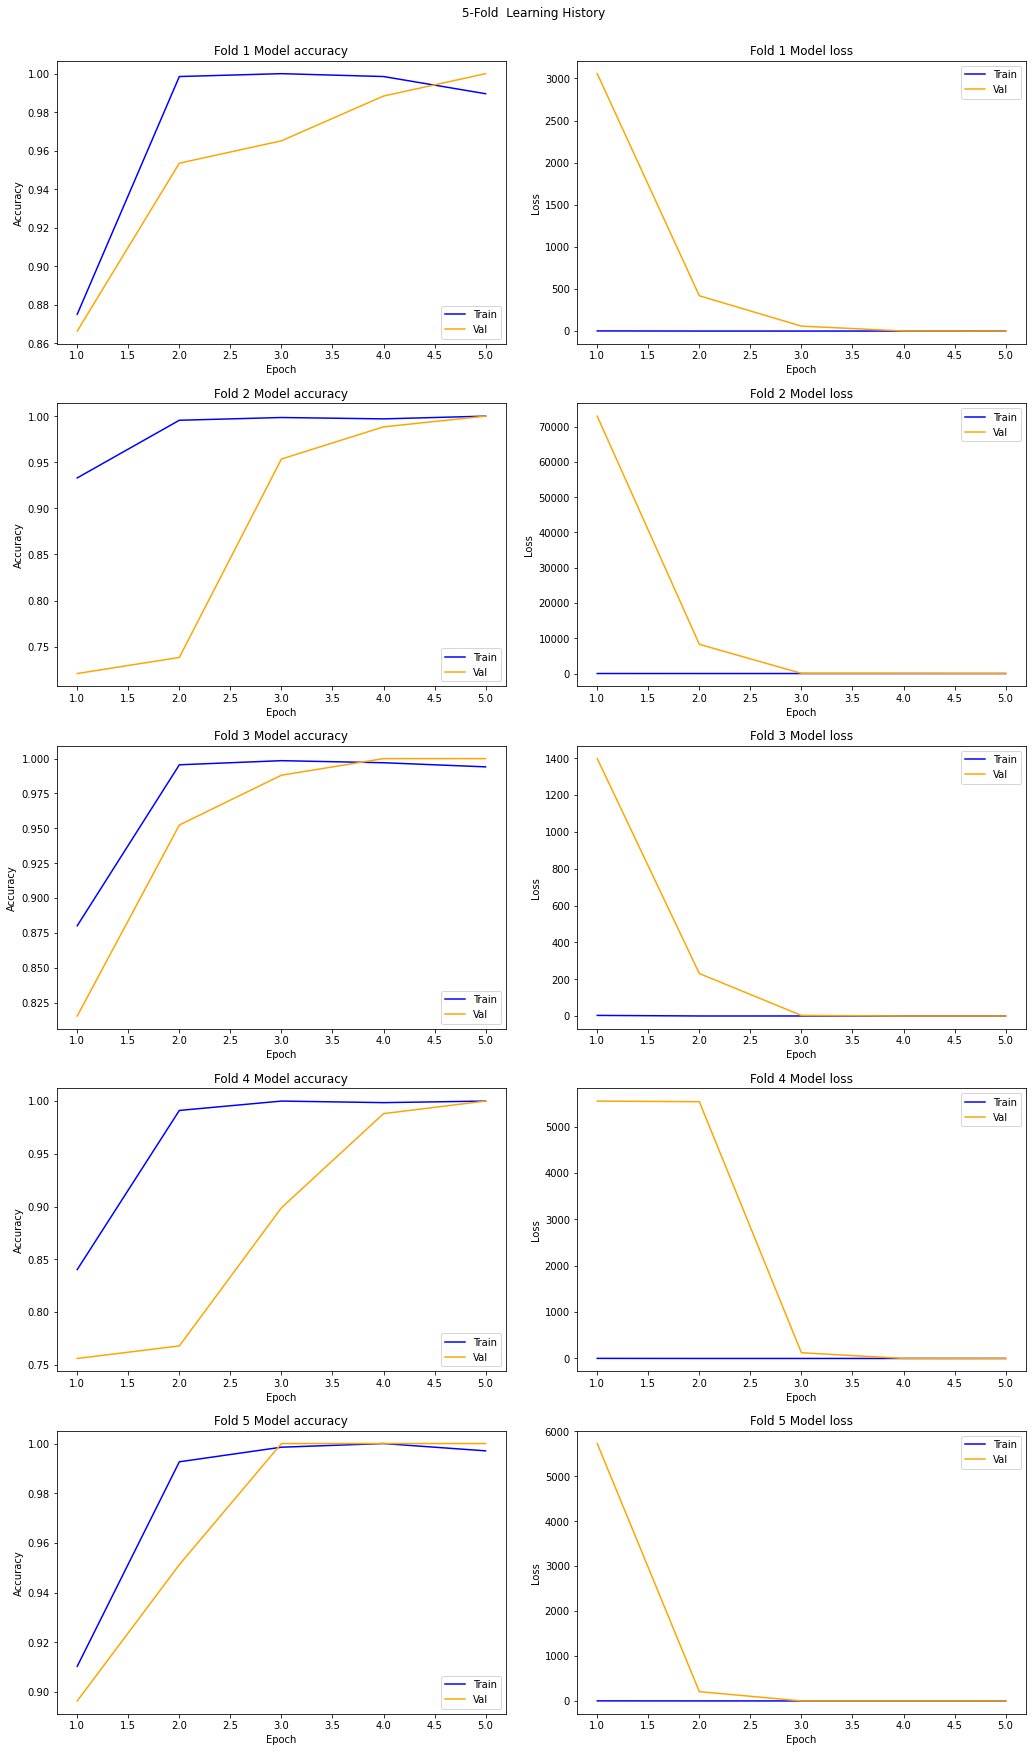

In [11]:
fig, axs = plt.subplots(K_Fold, 2, figsize=(15,(5*K_Fold)))
fig.tight_layout(pad=4.0)
fig.subplots_adjust(top=0.95)
fig.suptitle(str(K_Fold)+'-Fold '+' Learning History')
epoch_range = range(1, Num_Epochs+1)
for i in range(0,K_Fold):
    axs[i,0].plot(epoch_range, Output_Data[i][0],color='blue')
    axs[i,0].plot(epoch_range, Output_Data[i][1],color='orange')
    axs[i,0].set_title('Fold '+str(i+1)+' Model accuracy')
    axs[i,0].set_ylabel('Accuracy')
    axs[i,0].set_xlabel('Epoch')
    axs[i,0].legend(['Train', 'Val'], loc='lower right')
    
    axs[i,1].plot(epoch_range, Output_Data[i][2],color='blue')
    axs[i,1].plot(epoch_range, Output_Data[i][3],color='orange')
    axs[i,1].set_title('Fold '+str(i+1)+' Model loss')
    axs[i,1].set_ylabel('Loss')
    axs[i,1].set_xlabel('Epoch')
    axs[i,1].legend(['Train', 'Val'], loc='upper right')

### Testing and Visualizing prediction

In [6]:
#Function to predict if the given image is of Chondrocytes or a Stemcells
lmodel = createResNetModel()
lmodel.load_weights("resnet50_2.h5")
CATEGORIES = ["Chondrocytes", "Stemcells"]
def predict(file):
    img_array = cv2.imread(file)
    new_array = cv2.resize(img_array, (pix, pix))
    prepared = new_array.reshape(-1, pix, pix, 3)
    prediction = lmodel.predict(prepared)
    prediction= list(prediction[0])
    return CATEGORIES[prediction.index(max(prediction))] , new_array

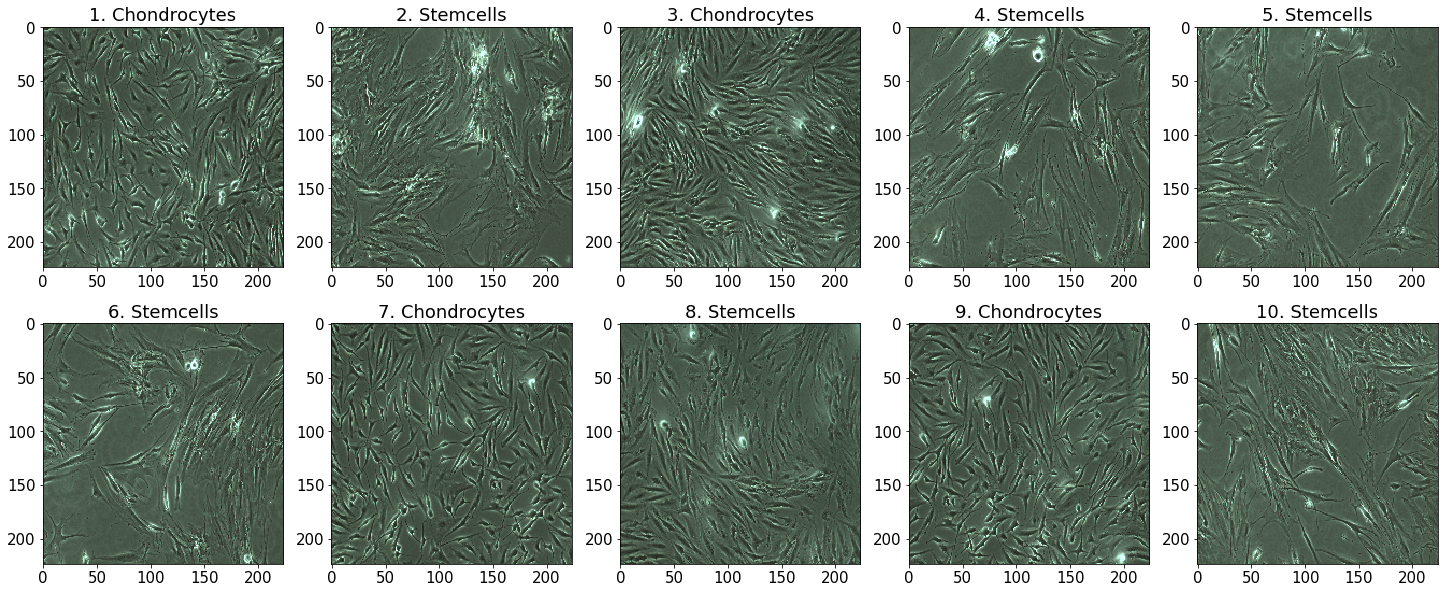

In [7]:
path = 'D:/RWTH_CAME/3rd_sem/Computational_Intelligence/project2/Test-both/'
fig=plt.figure(figsize=(25, 10))
columns = 5
rows = 2
plt.rc('font', size=15)
for i in range(1,11):  
    image = path+str(i)+'.tif' #your image path
    prediction , reshaped = predict(image)
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(reshaped)
    ax.set_title(str(i)+'. '+prediction)
plt.show()